In [ ]:
import pandas as pd
import requests

url = "https://www.anbima.com.br/informacoes/est-termo/CZ.asp"

try:
    response = requests.get(url)
    response.raise_for_status() # Levanta um erro para status 4xx/5xx

    # pandas.read_html tenta encontrar todas as tabelas HTML na string ou URL
    # decimal=',' e thousands='.' são importantes para o formato numérico brasileiro
    tabelas = pd.read_html(response.text, decimal=',', thousands='.')

    if tabelas:
        print(f"Encontradas {len(tabelas)} tabelas HTML na página.")
        # Geralmente, a tabela que você quer é a primeira, ou você pode precisar inspecionar
        # os resultados para encontrar a tabela correta.
        df_base_de_dados = tabelas[0] # Pega a primeira tabela encontrada
        print("\nBase de dados (DataFrame) encontrada:")
        print(df_base_de_dados.head())
    else:
        print("Nenhuma tabela HTML encontrada com pandas.read_html.")

except requests.exceptions.RequestException as e:
    print(f"Erro na requisição HTTP: {e}")
except ValueError:
    print("Erro ao parsear HTML: Nenhuma tabela encontrada ou formato inválido.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Erro ao parsear HTML: Nenhuma tabela encontrada ou formato inválido.


/tmp/ipykernel_3399/1583379703.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabelas = pd.read_html(response.text, decimal=',', thousands='.')


In [ ]:
 import ipeadatapy as ipea
 
 df_ettj = ipea.timeseries('ANBIMA12_TJTLN112')

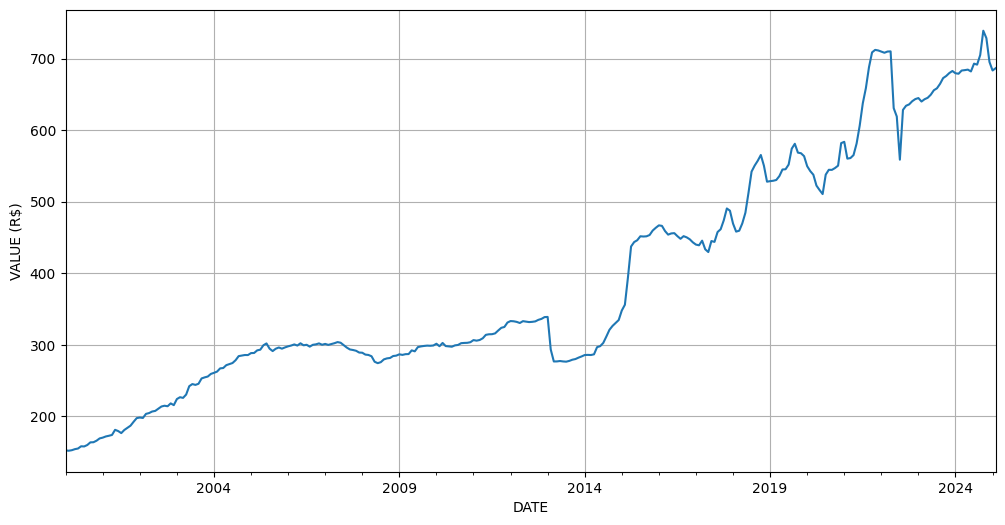

                          CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                          
2000-01-01  ELETRO12_CEETRES12  2000-01-01T00:00:00-02:00    1      1  2000   
2000-02-01  ELETRO12_CEETRES12  2000-02-01T00:00:00-02:00    1      2  2000   
2000-03-01  ELETRO12_CEETRES12  2000-03-01T00:00:00-03:00    1      3  2000   
2000-04-01  ELETRO12_CEETRES12  2000-04-01T00:00:00-03:00    1      4  2000   
2000-05-01  ELETRO12_CEETRES12  2000-05-01T00:00:00-03:00    1      5  2000   

            VALUE (R$)  
DATE                    
2000-01-01  152.412150  
2000-02-01  152.031574  
2000-03-01  152.766800  
2000-04-01  154.231380  
2000-05-01  155.108657  


In [51]:
import matplotlib.pyplot as plt

df_energia = ipea.timeseries('ELETRO12_CEETRES12')
df_energia = df_energia['2000-01-01 00:00:00':]

plt.figure(figsize=(12, 6))
df_energia['VALUE (R$)'].plot()
plt.xlabel('DATE')
plt.ylabel('VALUE (R$)')
plt.grid(True)
plt.show()

print(df_energia.head())


In [23]:
ipea.list_series()


,CODE,NAME
0,ABATE_ABPEAV,Abate - aves - peso das carcaças
1,ABATE_ABQUBV,Abate - bovinos - quantidade
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças
3,ABATE12_ABQUBO12,Abate - bois - quantidade
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade
...,...,...
2797,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...
2798,PNAD_IAGRV,Domicílios com insegurança alimentar grave
2799,PNAD_IALEV,Domicílios com insegurança alimentar leve
2800,PNAD_IAMOD,Domicílios com insegurança alimentar moderada


In [92]:
titulos = pd.read_excel('dados/titulos-publicos-precos-06-06-2025-17-27-58.xls')

titulos['Prazo'] = pd.to_datetime(titulos['Data de vencimento'], format= '%d/%m/%Y') - pd.to_datetime(titulos['Data de referência'], format= '%d/%m/%Y')
titulos['Prazo'] = titulos['Prazo'].dt.days



/home/hspassos/anaconda3/envs/bcb/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [94]:
import numpy as np

titulos = titulos[titulos['Tipo do título'] == 'LTN']

def svensson_model(m, params):
    """
    Calcula a taxa de juros de acordo com o modelo de Svensson.

    Args:
        m (float or np.array): Vencimento (maturidade) em anos.
        params (list or np.array): Lista ou array dos 6 parâmetros [beta0, beta1, beta2, beta3, tau1, tau2].

    Returns:
        float or np.array: Taxa de juros prevista pelo modelo para o vencimento m.
    """
    beta0, beta1, beta2, beta3, tau1, tau2 = params

    # Evitar divisão por zero para m muito pequeno
    m_safe = np.where(m == 0, 1e-9, m)

    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-m_safe / tau1)) / (m_safe / tau1))
    term3 = beta2 * ((1 - np.exp(-m_safe / tau1)) / (m_safe / tau1) - np.exp(-m_safe / tau1))
    term4 = beta3 * ((1 - np.exp(-m_safe / tau2)) / (m_safe / tau2) - np.exp(-m_safe / tau2))

    return term1 + term2 + term3 + term4

def objective_function(params, maturities_obs, yields_obs):
    """
    Função objetivo para minimizar a soma dos quadrados dos erros.

    Args:
        params (list or np.array): Parâmetros do modelo de Svensson a serem otimizados.
        maturities_obs (np.array): Vencimentos observados no mercado.
        yields_obs (np.array): Taxas de juros observadas no mercado correspondentes aos vencimentos.

    Returns:
        float: Soma dos quadrados dos erros.
    """
    predicted_yields = svensson_model(maturities_obs, params)
    errors = yields_obs - predicted_yields
    return np.sum(errors**2)

maturities_obs = np.array(titulos['Prazo'])
yields_obs = np.array(titulos['Taxa indicativa'])

Estimação bem-sucedida. Parâmetros do Svensson: [ 13.48069663   5.23541863   5.18229772   4.03746252   2.16393146
 103.16860123]
Soma dos quadrados dos erros (RSS): 1.5828985269744063


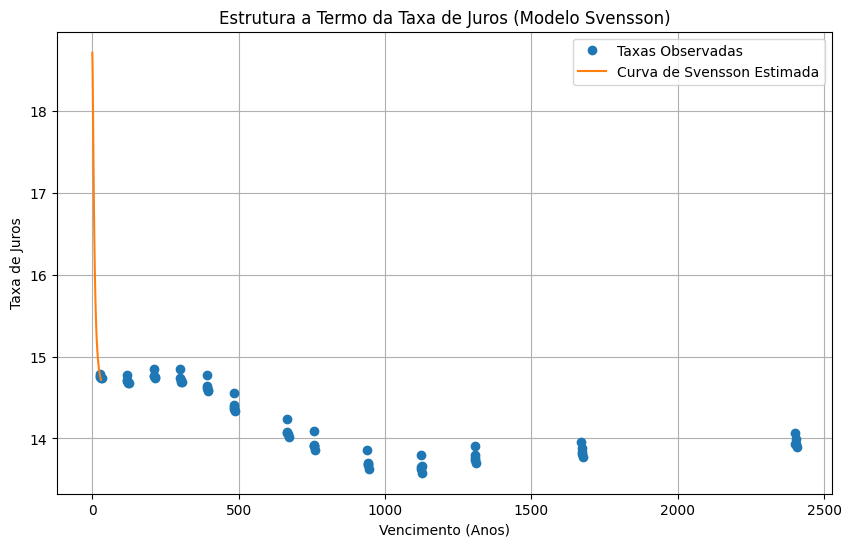

In [95]:
from scipy.optimize import minimize

initial_params = [0.05, -0.01, 0.01, -0.005, 1.0, 5.0]

# Restrições (opcional, mas recomendado para tau1 e tau2 serem positivos)
bounds = ((None, None), (None, None), (None, None), (None, None), (1e-6, None), (1e-6, None))

# Realizar a otimização
result = minimize(objective_function, initial_params, args=(maturities_obs, yields_obs),
                  method='L-BFGS-B', bounds=bounds)

# Exibir os resultados
if result.success:
    estimated_params = result.x
    print(f"Estimação bem-sucedida. Parâmetros do Svensson: {estimated_params}")
    print(f"Soma dos quadrados dos erros (RSS): {result.fun}")

    # Gerar a curva estimada
    maturities_plot = np.linspace(0.1, 30, 100) # Para uma curva suave
    estimated_yields = svensson_model(maturities_plot, estimated_params)

    # Plotar a curva
    plt.figure(figsize=(10, 6))
    plt.plot(maturities_obs, yields_obs, 'o', label='Taxas Observadas')
    plt.plot(maturities_plot, estimated_yields, label='Curva de Svensson Estimada')
    plt.title('Estrutura a Termo da Taxa de Juros (Modelo Svensson)')
    plt.xlabel('Vencimento (Anos)')
    plt.ylabel('Taxa de Juros')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("A otimização não convergiu.")
    print(result)